# Import Libraries

In [23]:
#Import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Define custom dataset class

In [24]:
class RetrofitDataset(Dataset):
    def __init__(self, data, targets):
        # Convert data and target into PyTorch tensors and store them
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = [torch.tensor(t, dtype=torch.float32) for t in targets]

    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get the feature vector and corresponding targets for a given index
        x = self.data[idx]
        y = [t[idx] for t in self.targets]
        return x, y


# Load and preprocess data

In [25]:
def load_data(file_path=r"C:\Users\isabella.lucchese\Desktop\Graduation\Excel sheets\Inputs_Try.csv"):
    # Load data from CSV file into a Pandas DataFrame
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    # Extract features (X) and target variables (y)
    # Assumes data includes necessary columns like 'Window_Cost', 'Floor_Cost', etc.
    
    X = data[['Window_U_value', 'Floor_Rc_value', 'Facade_Rc_value', 'Roof_Rc_value']]
    
    # Function to calculate total cost based on U-values and Rc-values
    def calculate_total_cost(row):
        return row['Window_Cost'] + row['Floor_Cost'] + row['Facade_Cost'] + row['Roof_Cost']

    # Function to calculate total embodied carbon based on U-values and Rc-values
    def calculate_total_embodied_carbon(row):
        return row['Window_Carbon'] + row['Floor_Carbon'] + row['Facade_Carbon'] + row['Roof_Carbon']

    # Function to calculate thermal discomfort based on internal temperature
    def calculate_thermal_discomfort(internal_temp, lower_bound=16, upper_bound=24):
        if internal_temp < lower_bound:
            return lower_bound - internal_temp #Discomfort for being too cold
        elif internal_temp > upper_bound:
            return internal_temp - upper_bound #Discomfort for being too hot
        return 0 # No discomfort if within the comfortable range

    # Apply the functions to calculate targets
    data['Total_Cost'] = data.apply(calculate_total_cost, axis=1)
    data['Total_Embodied_Carbon'] = data.apply(calculate_total_embodied_carbon, axis=1)
    data['Thermal_Discomfort'] = data['Internal_Temperature'].apply(calculate_thermal_discomfort)

    # Target variables
    y = [data['Energy_Consumption'].values, 
         data['Total_Cost'].values, 
         data['Total_Embodied_Carbon'].values, 
         data['Thermal_Discomfort'].values]

    # Normalize the features and target variables using StandardScaler
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Normalize target variables
    scalers_y = [StandardScaler() for _ in y]
    y_scaled = [scaler.fit_transform(target.reshape(-1, 1)) for scaler, target in zip(scalers_y, y)]
    
    return X_scaled, y_scaled, scalers_y, y

data = load_data()
X, y_scaled, scalers_y = preprocess_data(data)

ValueError: too many values to unpack (expected 3)

In [ ]:
data

,Building_Type,Window_U_value,Roof_Rc_value,Floor_Rc_value,Facade_Rc_value,Energy_Consumption,Internal_Temperature,Window_Cost,Roof_Cost,Floor_Cost,Facade_Cost,Window_Carbon,Roof_Carbon,Floor_Carbon,Facade_Carbon,Total_Cost,Total_Embodied_Carbon,Thermal_Discomfort
0,B1,0,0,0,0,246,16,0,0,0,0,0,0,0,0,0,0,0
1,B2,1,0,0,0,234,17,1000,0,0,0,1000,0,0,0,1000,1000,0
2,B3,2,0,0,0,233,18,2000,0,0,0,2000,0,0,0,2000,2000,0
3,B4,3,0,0,0,231,23,3000,0,0,0,3000,0,0,0,3000,3000,0
4,B5,0,1,0,0,230,18,0,1000,0,0,0,1000,0,0,1000,1000,0
5,B6,0,2,0,0,227,19,0,2000,0,0,0,2000,0,0,2000,2000,0
6,B7,0,3,0,0,224,22,0,3000,0,0,0,3000,0,0,3000,3000,0
7,B8,0,0,1,0,259,27,0,0,1000,0,0,0,1000,0,1000,1000,3
8,B9,0,0,2,0,259,22,0,0,2000,0,0,0,2000,0,2000,2000,0
9,B10,0,0,3,0,259,24,0,0,3000,0,0,0,3000,0,3000,3000,0


# Define the MTL Model

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, input_size):
        super(MultiTaskModel, self).__init__()
        
        # Define shared layers
        self.shared_fc1 = nn.Linear(input_size, 128)
        self.shared_fc2 = nn.Linear(128, 64)
        
        # Define task-specific layers for energy consumption
        self.energy_fc1 = nn.Linear(64, 32)
        self.energy_out = nn.Linear(32, 1)
        
        # Define task-specific layers for carbon emissions
        self.carbon_fc1 = nn.Linear(64, 32)
        self.carbon_out = nn.Linear(32, 1)
        
        # Define task-specific layers for costs
        self.costs_fc1 = nn.Linear(64, 32)
        self.costs_out = nn.Linear(32, 1)
        
        # Define task-specific layers for internal discomfort
        self.discomfort_fc1 = nn.Linear(64, 32)
        self.discomfort_out = nn.Linear(32, 1)

    def forward(self, x):
        # Pass input through shared layers
        x = torch.relu(self.shared_fc1(x))
        x = torch.relu(self.shared_fc2(x))
        
        # Pass shared representation through each task-specific head
        energy = torch.relu(self.energy_fc1(x))
        energy = self.energy_out(energy)
        
        carbon = torch.relu(self.carbon_fc1(x))
        carbon = self.carbon_out(carbon)
        
        costs = torch.relu(self.costs_fc1(x))
        costs = self.costs_out(costs)
        
        discomfort = torch.relu(self.discomfort_fc1(x))
        discomfort = self.discomfort_out(discomfort)
        
        # Return the outputs for all tasks
        return energy, carbon, costs, discomfort

# Example
input_size = X.shape[1]  # Number of input features
model = MultiTaskModel(input_size)  # Initialize the model


# Define the loss function and optimizer

In [ ]:
def get_loss_fn():
    return nn.MSELoss()

def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr=lr)

# Example
loss_fn = get_loss_fn()  # Get the loss function
optimizer = get_optimizer(model)  # Get the optimizer


# Train the model

In [ ]:
def train_model(model, dataloader, val_loader, loss_fn, optimizer, num_epochs=100, device='cuda'):
    # Move the model to the specified device (GPU or CPU)
    model = model.to(device)
    
    #Lists to store loss values
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0  # Track the total loss for this epoch
        
        # Iterate over the training batches
        for batch in dataloader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = [target.to(device).unsqueeze(1) for target in y_batch]
            
            optimizer.zero_grad()  # Zero out the gradients from the previous step
            
            # Forward pass
            predictions = model(X_batch)
            # Compute the loss for each task
            losses = [loss_fn(pred, target) for pred, target in zip(predictions, y_batch)]
            loss = sum(losses)  # Sum the losses for all tasks
            loss.backward()  # Backpropagation to compute gradients
            optimizer.step()  # Update the model parameters
            
            total_loss += loss.item()  # Accumulate the loss
        
        #Record the average training loss for this epoch
        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                X_val, y_val = val_batch
                X_val = X_val.to(device)
                y_val = [target.to(device).unsqueeze(1) for target in y_val]
                
                val_predictions = model(X_val)
                val_losses = [loss_fn(pred, target) for pred, target in zip(val_predictions, y_val)]
                val_loss += sum(val_losses).item()

        #Record the average validation loss for this epoch
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

        return train_losses, val_losses


# Evaluate the model

In [ ]:
def evaluate_model(model, dataloader, loss_fn, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = [target.to(device).unsqueeze(1) for target in y_batch]
            
            predictions = model(X_batch)
            losses = [loss_fn(pred, target) for pred, target in zip(predictions, y_batch)]
            total_loss += sum(losses).item()
    
    print(f'Evaluation Loss: {total_loss/len(dataloader)}')


# Save and load the model

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

# Example usage
save_model(model, 'mtl_retrofit_model.pth')

# To load the model
model = load_model(MultiTaskModel(input_size), 'mtl_retrofit_model.pth')


# Main execution and running the pipeline

In [ ]:
# Load and preprocess data
# Replace 'raw_simulation_data.csv' with the path to your specific dataset
data = load_data()
X, y_scaled, scaler_y = preprocess_data(data)

# Create dataset and dataloaders
dataset = RetrofitDataset(X, y_scaled)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Build, compile, and train model
input_size = X.shape[1]  # Number of input features
model = MultiTaskModel(input_size)  # Initialize the model
loss_fn = get_loss_fn()  # Get the loss function
optimizer = get_optimizer(model)  # Get the optimizer

# Train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100, device=device)

# Evaluate the model on the validation set
evaluate_model(model, val_loader, loss_fn, device=device)

# Save the trained model
save_model(model, 'mtl_retrofit_model.pth')

# Load the model and make predictions on new data
model = load_model(MultiTaskModel(input_size), 'mtl_retrofit_model.pth')
model = model.to(device)
model.eval()

# Replace with actual new data (formatted similarly to the input data)
new_data = torch.tensor([[1,2,3,0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    predictions = model(new_data)

# Inverse transform the predictions to real-world values using the correct scaler for each task
predictions_real = [scaler.inverse_transform(pred.cpu().numpy().flatten().reshape(-1, 1)) 
                    for scaler, pred in zip(scalers_y, predictions)]

    
# Print predictions for each task
print("Predictions (energy consumption, carbon emissions, costs, internal discomfort):")
for i, pred in enumerate(predictions_real):
    print(f"Task {i + 1} prediction: {pred.flatten()}")


NameError: name 'y' is not defined

# Printing graphs

Epoch 1/100, Training Loss: 10056559.0, Validation Loss: 2059567.25


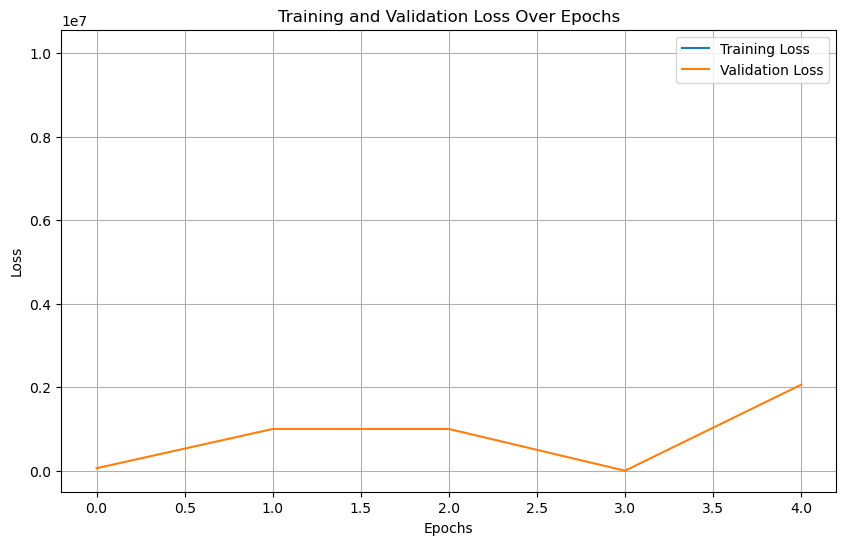

In [ ]:
# Train the model and collect the training and validation losses
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100, device=device)

# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

